
このノートブックを実行するには、次の追加ライブラリが必要です。 Colab での実行は実験的なものであることに注意してください。問題がある場合は、Github の問題を報告してください。


In [ ]:
!pip install d2l==1.0.0-beta0



# バッチ正規化

:label: `sec_batch_norm`

ディープ ニューラル ネットワークのトレーニングは困難です。適切な時間内にそれらを収束させるのは難しい場合があります。このセクションでは、ディープ ネットワークの収束を一貫して加速する一般的で効果的な手法である*バッチ正規化*について説明します (引用: `Ioffe.Szegedy.2015` )。残りのブロックと合わせて -- :numref: `sec_resnet`で後述します -- バッチ正規化により、実践者は 100 層を超えるネットワークを日常的にトレーニングできるようになりました。バッチ正規化の二次的な (偶然の) 利点は、バッチ正規化に固有の正規化にあります。


In [1]:
import torch
from torch import nn
from d2l import torch as d2l


## ディープネットワークのトレーニング

データを扱うときは、トレーニング前に前処理を行うことがよくあります。データの前処理に関する選択は、多くの場合、最終結果に大きな違いをもたらします。住宅価格の予測への MLP の適用 (:numref: `sec_kaggle_house` ) を思い出してください。実際のデータを扱うときの最初のステップは、複数の観測値にわたってゼロ平均 $\boldsymbol{\mu} = 0$ および単位分散 $\boldsymbol{\Sigma} = \boldsymbol{1}$ になるように入力特徴を標準化することでした :cite ： `friedman1987exploratory` 。少なくとも、対角が 1 になるように、つまり $\Sigma_{ii} = 1$ になるように、頻繁に再スケーリングします。さらに別の戦略は、ベクトルを単位長に再スケーリングし、場合によっては*観測ごとの*平均がゼロになることです。これは、空間センサー データなどにうまく機能します。これらの前処理技術やその他多くの技術は、推定の問題を適切に制御するのに役立ちます。特徴の選択と抽出技術のレビューについては、たとえば、:citet: `guyon2008feature`の記事を参照してください。ベクトルの標準化には、それに作用する関数の関数の複雑さを制限するという素晴らしい副作用もあります。たとえば、サポート ベクター マシンの有名な半径マージン境界 :cite: `Vapnik95`とパーセプトロン収束定理 :cite: `Novikoff62` 、有界ノルムの入力に依存しています。

直観的には、この標準化はパラメータを同様のスケールに*アプリオリ*に設定するため、オプティマイザとうまく連携します。したがって、深いネットワーク*内の*対応する正規化ステップが有益ではないのではないかと疑問に思うのは自然なことです。これは、バッチ正規化の発明に至った推論とまったく同じではありません :cite: `Ioffe.Szegedy.2015`が、バッチ正規化とそのいとこであるレイヤー正規化を理解するのに役立つ方法です :cite: `Ba.Kiros.Hinton.2016`統一された枠組み。

第 2 に、典型的な MLP または CNN の場合、トレーニング中に、中間層の変数 (MLP のアフィン変換出力など) は、入力から出力までの層に沿って、同じ層内のユニット全体で、大きく異なる大きさの値を取る可能性があります。モデルパラメータの更新により、時間の経過とともに変化します。バッチ正規化の発明者らは、このような変数の分布におけるドリフトがネットワークの収束を妨げる可能性があると非公式に仮定しました。直観的には、ある層の可変活性化が別の層の 100 倍である場合、学習率の補償調整が必要になる可能性があると推測できます。 AdaGrad :cite: `Duchi.Hazan.Singer.2011` 、Adam :cite: `Kingma.Ba.2014` 、Yogi :cite: `Zaheer.Reddi.Sachan.ea.2018` 、または Distributed Shampoo :cite: `anil2020scalable`などの適応ソルバーで対処することを目的としています。これは、最適化の観点から、たとえば二次メソッドの側面を追加することによって行われます。別の方法は、単に適応正規化によって問題の発生を防ぐことです。

第三に、より深いネットワークは複雑であり、過剰適合が起こりやすい傾向があります。これは、正則化がより重要になることを意味します。正則化の一般的な手法はノイズ注入です。これは、たとえば入力へのノイズ注入に関して、長い間知られていました:cite: `Bishop.1995` 。また、 :numref: `sec_dropout`のドロップアウトの基礎も形成します。結局のところ、非常に偶然なことに、バッチ正規化は、前処理、数値安定性、正則化という 3 つの利点をすべてもたらします。

バッチ正規化は、個々のレイヤー、またはオプションですべてのレイヤーに適用されます。各トレーニング反復では、まず、平均を減算し、標準偏差で割ることによって (バッチ正規化の) 入力を正規化します。両方とも統計に基づいて推定されます。現在のミニバッチの。次に、スケール係数とオフセットを適用して、失われた自由度を回復します。*バッチ正規化の*名前の由来は、まさに*バッチ*統計に基づくこの*正規化*によるものです。

サイズ 1 のミニバッチでバッチ正規化を適用しようとしても、何も学習できないことに注意してください。これは、平均を減算した後、各隠れユニットの値が 0 になるためです。ご想像のとおり、十分な大きさのミニバッチを使用してセクション全体をバッチ正規化に費やしているため、このアプローチは効果的で安定していることがわかります。ここで重要なことは、バッチ正規化を適用する場合、バッチ サイズの選択はバッチ正規化を適用しない場合よりもさらに重要であるか、少なくとも調整する可能性があるため、適切なキャリブレーションが必要であるということです。

 $\mathcal{B}$ でミニバッチを示し、$\mathbf{x} \in \mathcal{B}$ をバッチ正規化 ($\mathrm{BN}$) への入力とします。この場合、バッチ正規化は次のように定義されます。

 $$\mathrm{BN}(\mathbf{x}) = \boldsymbol{\gamma} \odot \frac{\mathbf{x} - \hat{\boldsymbol{\mu}} *\mathcal{B}}{\ hat{\boldsymbol{\sigma}}* \mathcal{B}} + \boldsymbol{\beta}.$$ :eqlabel: `eq_batchnorm`

 :eqref: `eq_batchnorm`では、 $\hat{\boldsymbol{\mu}} *\mathcal{B}$ は標本の平均値、 $\hat{\boldsymbol{\sigma}}* \mathcal{B}$ は標本の標準偏差です。ミニバッチ $\mathcal{B}$ の。標準化を適用すると、結果として得られるミニバッチの平均値と単位分散はゼロになります。単位分散 (他の魔法の数と比較して) の選択は任意です。 $\mathbf{x}$ と同じ形状を持つ要素ごとの*スケール パラメーター*$\boldsymbol{\gamma}$ と*シフト パラメーター*$\boldsymbol{\beta}$ を含めることで、この自由度を回復します。どちらもモデルのトレーニングの一部として学習する必要があるパラメーターです。

中間層の変数の大きさは、バッチ正規化によってアクティブに中央に配置され、特定の平均とサイズに再スケーリングされるため、訓練中に発散することはできません ($\hat{\boldsymbol{\mu}} *\mathcal{B}$ および ${\hat{ \boldsymbol{\sigma}}* \mathcal{B}}$)。実際の経験では、機能の再スケーリングについて説明したときにほのめかしたように、バッチ正規化によりより積極的な学習率が可能になるようであることが確認されています。 :eqref: `eq_batchnorm`の $\hat{\boldsymbol{\mu}} *\mathcal{B}$ と ${\hat{\boldsymbol{\sigma}}* \mathcal{B}}$ を次のように計算します。

 $$\hat{\boldsymbol{\mu}} *\mathcal{B} = \frac{1}{|\mathcal{B}|} \sum* {\mathbf{x} \in \mathcal{B}} \mathbf {x} \text{ および } \hat{\boldsymbol{\sigma}} *\mathcal{B}^2 = \frac{1}{|\mathcal{B}|} \sum* {\mathbf{x} \in \mathcal{B}} (\mathbf{x} - \hat{\boldsymbol{\mu}}_{\mathcal{B}})^2 + \epsilon.$$

経験的な分散推定値が非常に小さいか、あるいは消滅する可能性がある場合でも、ゼロによる除算が決して試行されないように、小さな定数 $\epsilon &gt; 0$ を分散推定値に追加していることに注意してください。 $\hat{\boldsymbol{\mu}} *\mathcal{B}$ と ${\hat{\boldsymbol{\sigma}}* \mathcal{B}}$ の推定値は、平均値と平均値のノイズの多い推定値を使用することでスケーリングの問題を打ち消します。分散。この騒音は問題だと思うかもしれません。それどころか、これは実際には有益です。

これはディープラーニングにおいて繰り返し起こるテーマであることが判明しました。理論的にはまだ十分に解明されていない理由により、最適化におけるさまざまなノイズ源がトレーニングの高速化と過学習の軽減につながることがよくあります。この変動は正則化の一形態として機能すると考えられます。 :citet: `Teye.Azizpour.Smith.2018`および :citet: `Luo.Wang.Shao.ea.2018`は、バッチ正規化の特性をそれぞれベイズ事前確率とペナルティに関連付けました。特に、$50 \sim 100$ の範囲の中程度のミニバッチ サイズでバッチ正規化が最適に機能する理由の謎に光が当てられます。この特定のサイズのミニバッチは、$\hat{\boldsymbol{\sigma}}$ によるスケールの点でも、$\hat{\boldsymbol によるオフセットの点でも、レイヤーごとにちょうど「適切な量」のノイズを注入しているようです。 {\mu}}$: 大きなミニバッチは推定値が安定するため正則化が少なくなりますが、小さなミニバッチは分散が大きいため有用な信号が破壊されます。この方向性をさらに探求し、代替タイプの前処理とフィルタリングを検討すると、他の効果的なタイプの正則化につながる可能性があります。

トレーニング済みモデルを修正すると、平均と分散を推定するためにデータセット全体を使用する方がよいと思われるかもしれません。トレーニングが完了したら、同じ画像が存在するバッチに応じて異なる方法で分類される必要があるのはなぜでしょうか。モデルを更新するたびにすべてのデータ例の中間変数が変化するため、トレーニング中はそのような正確な計算は不可能です。ただし、モデルがトレーニングされると、データセット全体に基づいて各レイヤーの変数の平均と分散を計算できます。実際、これはバッチ正規化を採用するモデルの標準的な手法であるため、バッチ正規化レイヤーの機能は*トレーニング モード*(ミニバッチ統計による正規化) と*予測モード*(データセット統計による正規化) では異なります。この形式では、ノイズがトレーニング中にのみ挿入される :numref: `sec_dropout`のドロップアウト正則化の動作によく似ています。

## バッチ正規化レイヤー

全結合層と畳み込み層のバッチ正規化実装は若干異なります。バッチ正規化と他のレイヤーの重要な違いの 1 つは、バッチ正規化は一度に完全なミニバッチに対して動作するため、他のレイヤーを導入するときに前に行ったようにバッチ ディメンションを無視することはできないことです。

### 完全に接続された層

全結合層にバッチ正規化を適用する場合、元の論文では、アフィン変換の後、非線形活性化関数*の前に*バッチ正規化を挿入しました。その後のアプリケーションでは、アクティベーション関数*の直後に*バッチ正規化を挿入する実験が行われました (引用: `Ioffe.Szegedy.2015` )。全結合層への入力を $\mathbf{x}$ で表し、アフィン変換を $\mathbf{W}\mathbf{x} + \mathbf{b}$ (重みパラメータ $\mathbf{W} で表す) $ とバイアス パラメーター $\mathbf{b}$)、$\phi$ による活性化関数を使用すると、バッチ正規化が有効な全結合層出力 $\mathbf{h}$ の計算を次のように表すことができます。 :

 $$\mathbf{h} = \phi(\mathrm{BN}(\mathbf{W}\mathbf{x} + \mathbf{b}) ).$$

平均と分散は、変換が適用される*同じ*ミニバッチで計算されることを思い出してください。

### 畳み込み層

同様に、畳み込み層を使用すると、畳み込みの後、非線形活性化関数の前にバッチ正規化を適用できます。完全に接続された層でのバッチ正規化との主な違いは、*すべての場所にわたって*チャネルごとに操作を適用することです。これは、畳み込みを引き起こす平行移動不変性の仮定と一致します。つまり、画像内のパターンの特定の位置は、理解する上で重要ではないと仮定しました。

ミニバッチに $m$ のサンプルが含まれており、各チャネルの畳み込みの出力の高さが $p$ で幅が $q$ であると仮定します。畳み込み層の場合、出力チャネルごとに $m \cdot p \cdot q$ 要素に対して各バッチ正規化を同時に実行します。したがって、平均と分散を計算するときにすべての空間位置にわたる値を収集し、その結果、特定のチャネル内で同じ平均と分散を適用して、各空間位置の値を正規化します。各チャンネルには独自のスケール パラメータとシフト パラメータがあり、どちらもスカラーです。

### レイヤーの正規化

:label: `subsec_layer-normalization-in-bn`

畳み込みのコンテキストでは、サイズ 1 のミニバッチに対してもバッチ正規化が明確に定義されていることに注意してください。結局のところ、平均する画像全体のすべての位置が得られます。したがって、たとえ単一の観測値内であっても、平均と分散は明確に定義されます。この考慮により、:citet: `Ba.Kiros.Hinton.2016`では、*レイヤー正規化*の概念が導入されました。これはバッチ基準と同じように機能しますが、一度に 1 つの観測値に適用される点が異なります。したがって、オフセットとスケーリング係数は両方ともスカラーです。 $n$ 次元ベクトル $\mathbf{x}$ が与えられると、層ノルムは次のように与えられます。

 $$\mathbf{x} \rightarrow \mathrm{LN}(\mathbf{x}) = \frac{\mathbf{x} - \hat{\mu}}{\hat\sigma},$$

ここで、スケーリングとオフセットは係数ごとに適用され、次のように与えられます。

 $$\hat{\mu} \stackrel{\mathrm{def}}{=} \frac{1}{n} \sum_{i=1}^n x_i \text{ and } \hat{\sigma}^ 2 \stackrel{\mathrm{def}}{=} \frac{1}{n} \sum_{i=1}^n (x_i - \hat{\mu})^2 + \epsilon.$$

前と同様に、ゼロ除算を防ぐために小さなオフセット $\epsilon &gt; 0$ を追加します。レイヤー正規化を使用する主な利点の 1 つは、発散を防止できることです。結局のところ、$\epsilon$ を無視すると、層正規化の出力はスケールに依存しません。つまり、$\alpha \neq 0$ の任意の選択に対して $\mathrm{LN}(\mathbf{x}) \about \mathrm{LN}(\alpha \mathbf{x})$ が得られます。これは $|\alpha| の等価になります。 \to \infty$ (近似的等価性は、分散のオフセット $\epsilon$ によるものです)。

レイヤー正規化のもう 1 つの利点は、ミニバッチ サイズに依存しないことです。また、トレーニング中かテスト中かにも依存しません。言い換えれば、これは、アクティベーションを所定のスケールに標準化する決定論的な変換にすぎません。これは、最適化における発散を防ぐのに非常に有益です。これ以上の詳細は省略し、興味のある読者は元の論文を参照することをお勧めします。

### 予測中のバッチ正規化

前述したように、バッチ正規化は通常、トレーニング モードと予測モードで異なる動作をします。まず、モデルをトレーニングした後は、ミニバッチでそれぞれを推定することで生じるサンプル平均値とサンプル分散のノイズは望ましくないものになります。次に、バッチごとの正規化統計を計算する余裕がない可能性があります。たとえば、一度に 1 つの予測を行うためにモデルを適用する必要がある場合があります。

通常、トレーニング後、データセット全体を使用して変数統計の安定した推定値を計算し、予測時にそれらを修正します。その結果、バッチ正規化の動作はトレーニング時とテスト時で異なります。ドロップアウトにもこの特性があることを思い出してください。

##  (**ゼロからの実装**)

バッチ正規化が実際にどのように機能するかを確認するために、以下でバッチ正規化を最初から実装します。


In [2]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # Use is_grad_enabled to determine whether we are in training mode
    if not torch.is_grad_enabled():
        # In prediction mode, use mean and variance obtained by moving average
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # When using a fully connected layer, calculate the mean and
            # variance on the feature dimension
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # When using a two-dimensional convolutional layer, calculate the
            # mean and variance on the channel dimension (axis=1). Here we
            # need to maintain the shape of X, so that the broadcasting
            # operation can be carried out later
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # In training mode, the current mean and variance are used
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # Update the mean and variance using moving average
        moving_mean = (1.0 - momentum) * moving_mean + momentum * mean
        moving_var = (1.0 - momentum) * moving_var + momentum * var
    Y = gamma * X_hat + beta  # Scale and shift
    return Y, moving_mean.data, moving_var.data


これで [**適切な`BatchNorm`レイヤーを作成できます。** ] 私たちの層はスケール`gamma`と シフト`beta`の適切なパラメーターを維持します。どちらもトレーニングの過程で更新されます。さらに、私たちのレイヤーは、その後のモデル予測中に使用するために、平均と分散の移動平均を維持します。

アルゴリズムの詳細はさておき、このレイヤーの実装の基礎となる設計パターンに注目してください。通常、数学は別の関数 (たとえば、 `batch_norm`で定義します。次に、この機能をカスタム レイヤーに統合します。そのコードは主に、データを適切なデバイス コンテキストに移動する、必要な変数の割り当てと初期化、移動平均 (ここでは平均と分散) の追跡などの簿記の問題に対処します。 。このパターンにより、定型コードから数学を明確に分離できます。また、便宜上、ここでは入力形状を自動的に推論することについては考慮していないため、全体で特徴の数を指定する必要があることにも注意してください。現在、すべての最新の深層学習フレームワークは、高レベルのバッチ正規化 API でサイズと形状の自動検出を提供しています (実際には、代わりにこれを使用します)。


In [3]:
class BatchNorm(nn.Module):
    # num_features: the number of outputs for a fully connected layer or the
    # number of output channels for a convolutional layer. num_dims: 2 for a
    # fully connected layer and 4 for a convolutional layer
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # The scale parameter and the shift parameter (model parameters) are
        # initialized to 1 and 0, respectively
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # The variables that are not model parameters are initialized to 0 and
        # 1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # If X is not on the main memory, copy moving_mean and moving_var to
        # the device where X is located
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # Save the updated moving_mean and moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.1)
        return Y


過去の平均と分散の推定値に対する集計を管理するために、 `momentum`利用しました。これは、 :numref: `sec_momentum`の最適化の*運動*量項とはまったく関係がないため、多少の誤りです。それにもかかわらず、これはこの用語に一般的に採用されている名前であり、API 命名規則に従って、コードでも同じ変数名を使用します。

##  [**バッチ正規化を使用した LeNet** ]

コンテキスト内で`BatchNorm`を適用する方法を確認するために、以下では、BatchNorm を従来の LeNet モデル (:numref: `sec_lenet` ) に適用します。バッチ正規化は、畳み込み層または全結合層の後、対応する活性化関数の前に適用されることを思い出してください。


In [4]:
class BNLeNetScratch(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5), BatchNorm(6, num_dims=4),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), BatchNorm(16, num_dims=4),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(), nn.LazyLinear(120),
            BatchNorm(120, num_dims=2), nn.Sigmoid(), nn.LazyLinear(84),
            BatchNorm(84, num_dims=2), nn.Sigmoid(),
            nn.LazyLinear(num_classes))


以前と同様に、[ **Fashion-MNIST データセットでネットワークをトレーニング**] します。このコードは、最初に LeNet を訓練したときのコードと実質的に同じです。


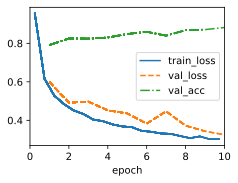

In [5]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = BNLeNetScratch(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)


最初のバッチ正規化層から学習した**スケール パラメーター`gamma`とシフト パラメーター`beta`を見てみましょう**。


In [6]:
model.net[1].gamma.reshape((-1,)), model.net[1].beta.reshape((-1,))

(tensor([1.7430, 1.9467, 1.6972, 1.5474, 2.0986, 1.8447], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>),
 tensor([ 0.9244, -1.3682,  1.4599, -1.5325,  1.3034, -0.0391], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>))


## [**簡潔な実装**]

自分たちで定義したばかりの`BatchNorm`クラスと比較して、高度な API で定義された`BatchNorm`クラスをディープ ラーニング フレームワークから直接使用できます。このコードは、寸法を正しくするために追加の引数を指定する必要がなくなったことを除けば、上記の実装と実質的に同じに見えます。


In [7]:
class BNLeNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5), nn.LazyBatchNorm2d(),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.LazyBatchNorm2d(),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(), nn.LazyLinear(120), nn.LazyBatchNorm1d(),
            nn.Sigmoid(), nn.LazyLinear(84), nn.LazyBatchNorm1d(),
            nn.Sigmoid(), nn.LazyLinear(num_classes))


以下では、**同じハイパーパラメータを使用してモデルをトレーニングします。** ] いつものように、高レベル API バリアントは、コードが C++ または CUDA にコンパイルされている一方で、カスタム実装は Python によって解釈される必要があるため、はるかに高速に実行されることに注意してください。


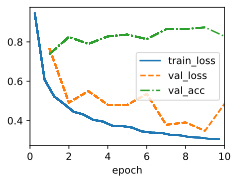

In [8]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = BNLeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)


## 議論

直感的には、バッチ正規化により、最適化の状況がよりスムーズになると考えられます。ただし、深いモデルをトレーニングするときに観察される現象についての推測的な直観と真の説明を区別することに注意する必要があります。そもそもなぜ単純なディープ ニューラル ネットワーク (MLP や従来の CNN) が一般化できるのかさえわかっていないことを思い出してください。ドロップアウトや重みの減衰があっても、非常に柔軟なままであるため、目に見えないデータを一般化する能力には、より洗練された学習理論による一般化の保証が必要になる可能性があります。

バッチ正規化を提案した元の論文:cite: `Ioffe.Szegedy.2015`では、強力で便利なツールの紹介に加えて、それが機能する理由について、*内部共変量シフト*を減らすことによって説明しました。おそらく*内部共変量シフト*とは、著者が上で表現した直観のようなもの、つまり変数値の分布がトレーニングの過程で変化するという概念を意味したのでしょう。しかし、この説明には 2 つの問題がありました。 i) このドリフトは*共変量シフト*とは大きく異なり、その名前が誤った名称になっています。どちらかというとコンセプトドリフトに近いです。 ii) この説明は、詳細が不明瞭な直観を提供しますが、*なぜこの手法が正確に機能するのか*という疑問は残り、厳密な説明が求められる未解決の疑問です。本書全体を通じて、私たちは実践者がディープ ニューラル ネットワークの開発をガイドするために使用する直観を伝えることを目的としています。しかし、私たちは、これらの指針となる直観を確立された科学的事実から切り離すことが重要であると信じています。最終的に、この内容をマスターして自分の研究論文を書き始めるとき、技術的な主張と予感との境界線を明確にする必要があるでしょう。

バッチ正規化の成功に続いて、*内部共変量シフト*に関するその説明が、機械学習の研究をどのように提示するかに関する技術文献や広範な議論の中で繰り返し浮上してきました。 2017 年の NeurIPS カンファレンスで Test of Time Award を受賞した記念すべきスピーチの中で、アリ・ラヒミ氏は、深層学習の現代の実践を錬金術に例えた議論の焦点として*内部共変量シフト*を使用しました。その後、この例は、機械学習における厄介な傾向を概説するポジションペーパーで詳細に再検討されました:cite: `Lipton.Steinhardt.2018` 。他の著者は、バッチ正規化の成功について別の説明を提案しており、元の論文で主張されているものとはある意味で反対の動作を示しているにもかかわらず、バッチ正規化の成功がもたらされると主張する人もいます:cite: `Santurkar.Tsipras.Ilyas.ea.2018` 。

*内部共変量シフトは、*機械学習の技術文献で毎年行われる何千もの同様の曖昧な主張と同様に批判に値しないことに注意してください。おそらく、これらの議論の焦点としてこの作品が反響を呼んでいるのは、対象とする視聴者に広く認知されているためだと思われます。バッチ正規化は、導入されているほぼすべての画像分類器に適用され、不可欠な方法であることが証明されており、この技術を紹介した論文は何万回も引用されています。しかし、ノイズ注入による正則化、再スケーリングによる高速化、そして最後に前処理という基本原則は、将来、さらなるレイヤーや技術の発明につながる可能性があると私たちは推測しています。

より実践的に言えば、バッチ正規化については覚えておく価値のある側面が数多くあります。
- モデルのトレーニング中、バッチ正規化ではミニバッチの平均と標準偏差を利用してネットワークの中間出力を継続的に調整するため、ニューラル ネットワーク全体の各層の中間出力の値がより安定します。
- 全結合層と畳み込み層のバッチ正規化は若干異なります。実際、畳み込み層の場合、層の正規化が代替として使用されることがあります。
- ドロップアウト層と同様に、バッチ正規化層はトレーニング モードと予測モードで異なる動作をします。
- バッチ正規化は、最適化における正規化と収束の向上に役立ちます。一方、内部共変量シフトを減らすという当初の動機は有効な説明ではないようです。
- 入力摂動の影響を受けにくい、より堅牢なモデルの場合は、バッチ正規化を削除することを検討してください:cite: `wang2022removing` 。

## 演習
1. バッチ正規化の前に全結合層または畳み込み層からバイアス パラメーターを削除する必要がありますか?なぜ？
1. バッチ正規化を使用した場合と使用しない場合の LeNet の学習率を比較します。<ol><li>検証精度の増加をプロットします。
1. どちらの場合も最適化が失敗する前に、学習率をどれくらい大きくできるでしょうか?
1. 確率積分変換を適用できますか?
1. フルランク共分散推定を使用できますか?おそらくそうすべきではないのはなぜでしょうか?
1. 他のコンパクトなマトリックス バリアント (ブロック対角、低変位ランク、モナークなど) を使用できますか?
1. スパース化圧縮は正則化として機能しますか?
1. 使用できる他の投影法 (凸円錐、対称グループ固有の変換など) はありますか?



[ディスカッション](https://discuss.d2l.ai/t/84)
